<a href="https://colab.research.google.com/github/Ebasurtos/Machine-Learning/blob/main/Proyecto_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Proyecto 3**

**Participantes:**

1.   Jorge Palacios   %
2.   Eder Basurto     %
3.   Rodolfo Morocho  %

**Carga de datos**

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

path = '/content/drive/MyDrive/ML_Data/leedsbutterfly/images'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
from PIL import Image
import numpy as np

def load_png_images(folder_path, target_size=(180, 180)):
    images = []
    img_shapes = []
    labels = []

    for file in os.listdir(folder_path):
        if file.endswith('.png'):
            # Extraer los primeros 3 caracteres del nombre del archivo como etiqueta
            label = file[:3]
            labels.append(label)

            img_path = os.path.join(folder_path, file)
            #img = Image.open(img_path).convert('L')  # Escala de grises
            img = Image.open(img_path).convert('RGB')  # Colores

            # Resize the image to the target size
            img_resized = img.resize(target_size)

            img_array = np.array(img_resized)
            img_flattened = img_array.flatten()
            images.append(img_flattened)
            img_shapes.append(img_array.shape)  # Guardar dimensiones (m, n)

    if not images:
        print("No PNG images found in the specified folder.")
        return None, None, 0, 0  # Return None for both X and Y, and zeros for dimensions

    X = np.array(images).T  # Cada columna es una imagen
    Y = np.array(labels)    # Array de etiquetas

    print("Total dataset size:")
    print(f"n_samples: {X.shape[1]}")
    print(f"n_features: {X.shape[0]}")
    print(f"Labels extracted: {len(Y)}")

    # Suponemos que todas las imágenes tienen las mismas dimensiones after resizing
    m, n = target_size
    return X, Y, m, n

X, Y, m, n = load_png_images(path, target_size=(180, 180))

Total dataset size:
n_samples: 850
n_features: 97200
Labels extracted: 850


**Vista de una imagen con su etiqueta**

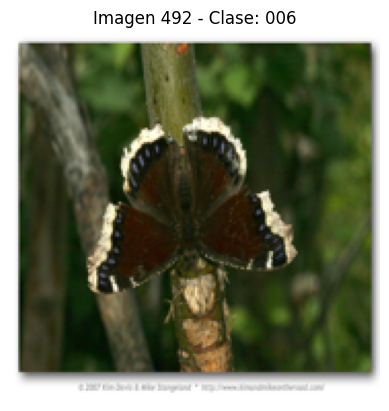

In [9]:
import random
import matplotlib.pyplot as plt

num_rand = random.randint(0, X.shape[1]-1)

#plt.imshow(X[:, num_rand].reshape(m, n), cmap='gray')
plt.imshow(X[:, num_rand].reshape(m, n, 3) / 255.0)

plt.title(f"Imagen {num_rand} - Clase: {Y[num_rand]}")
plt.axis('off')
plt.show()

# **1. Red Neuronal**

**División en Entrenamiento, Validación y Prueba**

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_temp, y_train, y_temp = train_test_split(
    X.T, Y, test_size=0.2, random_state=42, stratify=Y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Entrenamiento: {X_train.shape[0]} imágenes ({X_train.shape[0]/len(Y)*100:.1f}%)")
print(f"Validación: {X_val.shape[0]} imágenes ({X_val.shape[0]/len(Y)*100:.1f}%)")
print(f"Prueba: {X_test.shape[0]} imágenes ({X_test.shape[0]/len(Y)*100:.1f}%)")

# Opcional: Si necesitas las imágenes en formato (m, n, canales) en lugar de aplanadas
# (asumiendo que originalmente eran de tamaño (m, n, 3))
X_train_images = X_train.reshape(-1, m, n, 3)
X_val_images = X_val.reshape(-1, m, n, 3)
X_test_images = X_test.reshape(-1, m, n, 3)

Entrenamiento: 665 imágenes (79.9%)
Validación: 83 imágenes (10.0%)
Prueba: 84 imágenes (10.1%)


**Convertir datos a tensores**

In [ ]:
import torch
X_train_t = torch.FloatTensor(X_train).reshape(-1, 3, m, n)  # [N, C, H, W]
X_val_t = torch.FloatTensor(X_val).reshape(-1, 3, m, n)
X_test_t = torch.FloatTensor(X_test).reshape(-1, 3, m, n)

**Convertir Etiquetas a Indices numericos**

In [ ]:
# Convert string labels to numerical indices
classes = np.unique(Y)
y_train_t = torch.LongTensor(np.array([np.where(classes == y)[0][0] for y in y_train]))
y_val_t = torch.LongTensor(np.array([np.where(classes == y)[0][0] for y in y_val]))
y_test_t = torch.LongTensor(np.array([np.where(classes == y)[0][0] for y in y_test]))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

**Crear Dataset y Loaders**

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

# Verificación
print(f"Número de batches de entrenamiento: {len(train_loader)}")
print(f"Número de batches de validación: {len(val_loader)}")
print(f"Número de batches de prueba: {len(test_loader)}")
print(f"Tamaño de un batch de entrenamiento: {next(iter(train_loader))[0].shape}")
print(f"Tamaño de un batch de validación: {next(iter(val_loader))[0].shape}")
print(f"Tamaño de un batch de prueba: {next(iter(test_loader))[0].shape}")

Número de batches de entrenamiento: 42
Número de batches de validación: 6
Número de batches de prueba: 6
Tamaño de un batch de entrenamiento: torch.Size([16, 3, 180, 180])
Tamaño de un batch de validación: torch.Size([16, 3, 180, 180])
Tamaño de un batch de prueba: torch.Size([16, 3, 180, 180])


**Implementacion del  modelo**

In [ ]:
class ConfigurableMLP(nn.Module):
    def __init__(self, input_size, layer_configs, num_classes):

        super(ConfigurableMLP, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Flatten())
        prev_size = input_size

        # Hidden layers with individual activations
        for neurons, activation in layer_configs:
            self.layers.append(nn.Linear(prev_size, neurons))
            self.layers.append(self._get_activation(activation))
            prev_size = neurons

        # Output layer (no activation for CrossEntropyLoss)
        self.layers.append(nn.Linear(prev_size, num_classes))

    def _get_activation(self, activation_name):
        """Return activation function based on name"""
        activation_dict = {
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU(),
            'selu': nn.SELU(),
            'none': nn.Identity()  # No activation
        }
        return activation_dict.get(activation_name.lower(), nn.ReLU())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

**Obtener optimizador basado en la configuración**

In [ ]:
def get_optimizer(model, optimizer_name, lr, **kwargs):
    if optimizer_name.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=lr,
                         weight_decay=kwargs.get('weight_decay', 0.0),
                         betas=kwargs.get('betas', (0.9, 0.999)))

    elif optimizer_name.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=lr,
                        momentum=kwargs.get('momentum', 0.0),
                        weight_decay=kwargs.get('weight_decay', 0.0),
                        nesterov=kwargs.get('nesterov', False))

    elif optimizer_name.lower() == 'adamw':
        return optim.AdamW(model.parameters(), lr=lr,
                          weight_decay=kwargs.get('weight_decay', 0.0))

    elif optimizer_name.lower() == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=lr,
                            momentum=kwargs.get('momentum', 0.0),
                            weight_decay=kwargs.get('weight_decay', 0.0))

    elif optimizer_name.lower() == 'adagrad':
        return optim.Adagrad(model.parameters(), lr=lr,
                            weight_decay=kwargs.get('weight_decay', 0.0))

    else:
        return optim.Adam(model.parameters(), lr=lr)

**Función de entrenamiento**

In [ ]:
def train_model_advanced(config):
    input_size = 3 * m * n

    model = ConfigurableMLP(
        input_size=input_size,
        layer_configs=config['layer_configs'],
        num_classes=len(classes)
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Using device: {device}")

    criterion = nn.CrossEntropyLoss()

    optimizer_config = {}
    if config['optimizer'].lower() == 'sgd':
        optimizer_config['momentum'] = config.get('momentum', 0.9)
    elif config['optimizer'].lower() == 'rmsprop':
        optimizer_config['momentum'] = config.get('momentum', 0.0)

    optimizer_config['weight_decay'] = config.get('weight_decay', 0.0)

    optimizer = get_optimizer(
        model,
        config['optimizer'],
        config['lr'],
        **optimizer_config
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    ) if config.get('use_scheduler', False) else None

    # Training loop
    train_losses, val_losses = [], []
    train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    best_val_loss = float('inf')
    # Initialize best_model_state with the initial state
    best_model_state = model.state_dict().copy()

    for epoch in range(config['epochs']):
        # Training phase
        model.train()
        epoch_train_loss = 0
        all_preds, all_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            if config.get('grad_clip', 0) > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])

            optimizer.step()

            epoch_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Calculate training metrics
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_metrics['accuracy'].append(accuracy_score(all_labels, all_preds))
        train_metrics['precision'].append(precision_score(all_labels, all_preds, average='macro', zero_division=0))
        train_metrics['recall'].append(recall_score(all_labels, all_preds, average='macro', zero_division=0))
        train_metrics['f1'].append(f1_score(all_labels, all_preds, average='macro', zero_division=0))

        # Validation phase
        model.eval()
        epoch_val_loss = 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate validation metrics
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_metrics['accuracy'].append(accuracy_score(all_labels, all_preds))
        val_metrics['precision'].append(precision_score(all_labels, all_preds, average='macro', zero_division=0))
        val_metrics['recall'].append(recall_score(all_labels, all_preds, average='macro', zero_division=0))
        val_metrics['f1'].append(f1_score(all_labels, all_preds, average='macro', zero_division=0))

        # Learning rate scheduling
        if scheduler:
            scheduler.step(avg_val_loss)

        # Save best model if validation loss improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()

        print(f"Epoch {epoch+1}/{config['epochs']} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_metrics['accuracy'][-1]:.4f} | Val Acc: {val_metrics['accuracy'][-1]:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Load best model state after training
    model.load_state_dict(best_model_state)

    # Visualization (assuming these functions are defined elsewhere)
    visualize_results(train_losses, val_losses, train_metrics, val_metrics, all_labels, all_preds, classes)


    return model, train_metrics, val_metrics

**Función de Visualización**

In [ ]:
def visualize_results(train_losses, val_losses, train_metrics, val_metrics, true_labels, pred_labels, classes):
    plt.figure(figsize=(15, 12))

    # Loss curves
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Val Loss', linewidth=2)
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy curves
    plt.subplot(2, 3, 2)
    plt.plot(train_metrics['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(val_metrics['accuracy'], label='Val Accuracy', linewidth=2)
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Confusion matrix
    plt.subplot(2, 3, 3)
    conf_mat = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    # Metrics comparison
    plt.subplot(2, 3, 4)
    metrics_names = ['Precision', 'Recall', 'F1-Score']
    train_values = [
        np.mean(train_metrics['precision']),
        np.mean(train_metrics['recall']),
        np.mean(train_metrics['f1'])
    ]
    val_values = [
        np.mean(val_metrics['precision']),
        np.mean(val_metrics['recall']),
        np.mean(val_metrics['f1'])
    ]

    x = np.arange(len(metrics_names))
    width = 0.35
    plt.bar(x - width/2, train_values, width, label='Train', alpha=0.8)
    plt.bar(x + width/2, val_values, width, label='Val', alpha=0.8)
    plt.title('Metrics Comparison')
    plt.xticks(x, metrics_names)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # F1-Score progression
    plt.subplot(2, 3, 5)
    plt.plot(train_metrics['f1'], label='Train F1', linewidth=2)
    plt.plot(val_metrics['f1'], label='Val F1', linewidth=2)
    plt.title('F1-Score Progression')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Learning curves (train vs val)
    plt.subplot(2, 3, 6)
    plt.plot(train_metrics['accuracy'], label='Train Acc', linewidth=2)
    plt.plot(val_metrics['accuracy'], label='Val Acc', linewidth=2)
    plt.plot(train_metrics['f1'], label='Train F1', linestyle='--', linewidth=2)
    plt.plot(val_metrics['f1'], label='Val F1', linestyle='--', linewidth=2)
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [ ]:
# 8. Evaluación en test
def evaluate_model_comprehensive(model, loader, device='cpu'):
    model.eval()
    model.to(device)

    all_preds, all_labels = [], []
    total_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate all metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    conf_mat = confusion_matrix(all_labels, all_preds)
    avg_loss = total_loss / len(loader)

    print(f"\n{'='*50}")
    print(f"COMPREHENSIVE TEST EVALUATION")
    print(f"{'='*50}")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy:    {accuracy:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(conf_mat)

    # Per-class metrics
    print(f"\nPer-class metrics:")
    for i, cls in enumerate(classes):
        cls_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)[i]
        cls_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)[i]
        cls_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)[i]
        print(f"  {cls}: Precision={cls_precision:.3f}, Recall={cls_recall:.3f}, F1={cls_f1:.3f}")

    return accuracy, precision, recall, f1, conf_mat

**Configuración de Parámetros**

In [ ]:
configs = {
    # Configuración 1: MLP simple con ReLU y Adam
    'simple_relu_adam': {
        'layer_configs': [(512, 'relu'), (256, 'relu')],
        'optimizer': 'adam',
        'lr': 0.0008,
        'epochs': 50,
        'weight_decay': 1e-5  # weight_decay para Adam
    },

    # Configuración 2: MLP con SGD y momentum
    'sgd_momentum': {
        'layer_configs': [(512, 'relu'), (256, 'relu'), (128, 'relu')],
        'optimizer': 'sgd',
        'lr': 0.01,
        'epochs': 50,
        'momentum': 0.9,  # momentum solo para SGD
        'weight_decay': 1e-4,
        'use_scheduler': True
    },

    # Configuración 3: MLP con RMSprop y momentum
    'rmsprop_momentum': {
        'layer_configs': [(1024, 'tanh'), (512, 'tanh')],
        'optimizer': 'rmsprop',
        'lr': 0.0008,
        'epochs': 50,
        'momentum': 0.9,  # momentum para RMSprop
        'weight_decay': 1e-5
    },

    # Configuración 4: MLP con AdamW
    'adamw_config': {
        'layer_configs': [(1024, 'leaky_relu'), (512, 'elu'), (256, 'relu')],
        'optimizer': 'adamw',
        'lr': 0.0008,
        'epochs': 50,
        'weight_decay': 1e-4  # weight_decay para AdamW
    }
}

**Ejecutar entrenamiento**

Available configurations:
1. simple_relu_adam: [(512, 'relu'), (256, 'relu')]
2. sgd_momentum: [(512, 'relu'), (256, 'relu'), (128, 'relu')]
3. rmsprop_momentum: [(1024, 'tanh'), (512, 'tanh')]
4. adamw_config: [(1024, 'leaky_relu'), (512, 'elu'), (256, 'relu')]

Training with configuration: simple_relu_adam
Layers: [(512, 'relu'), (256, 'relu')]
Optimizer: adam
Learning rate: 0.0008
Momentum: N/A
Weight decay: 1e-05
Using device: cpu
Epoch 1/50 | Train Loss: 2093.8696 | Val Loss: 507.3071 | Train Acc: 0.1353 | Val Acc: 0.1084 | LR: 0.000800
Epoch 2/50 | Train Loss: 228.5044 | Val Loss: 78.3193 | Train Acc: 0.1669 | Val Acc: 0.2651 | LR: 0.000800
Epoch 3/50 | Train Loss: 44.6675 | Val Loss: 51.5345 | Train Acc: 0.2857 | Val Acc: 0.1687 | LR: 0.000800
Epoch 4/50 | Train Loss: 23.9941 | Val Loss: 20.7596 | Train Acc: 0.3609 | Val Acc: 0.2651 | LR: 0.000800
Epoch 5/50 | Train Loss: 13.1650 | Val Loss: 17.2899 | Train Acc: 0.4571 | Val Acc: 0.3373 | LR: 0.000800
Epoch 6/50 | Train Loss: 10

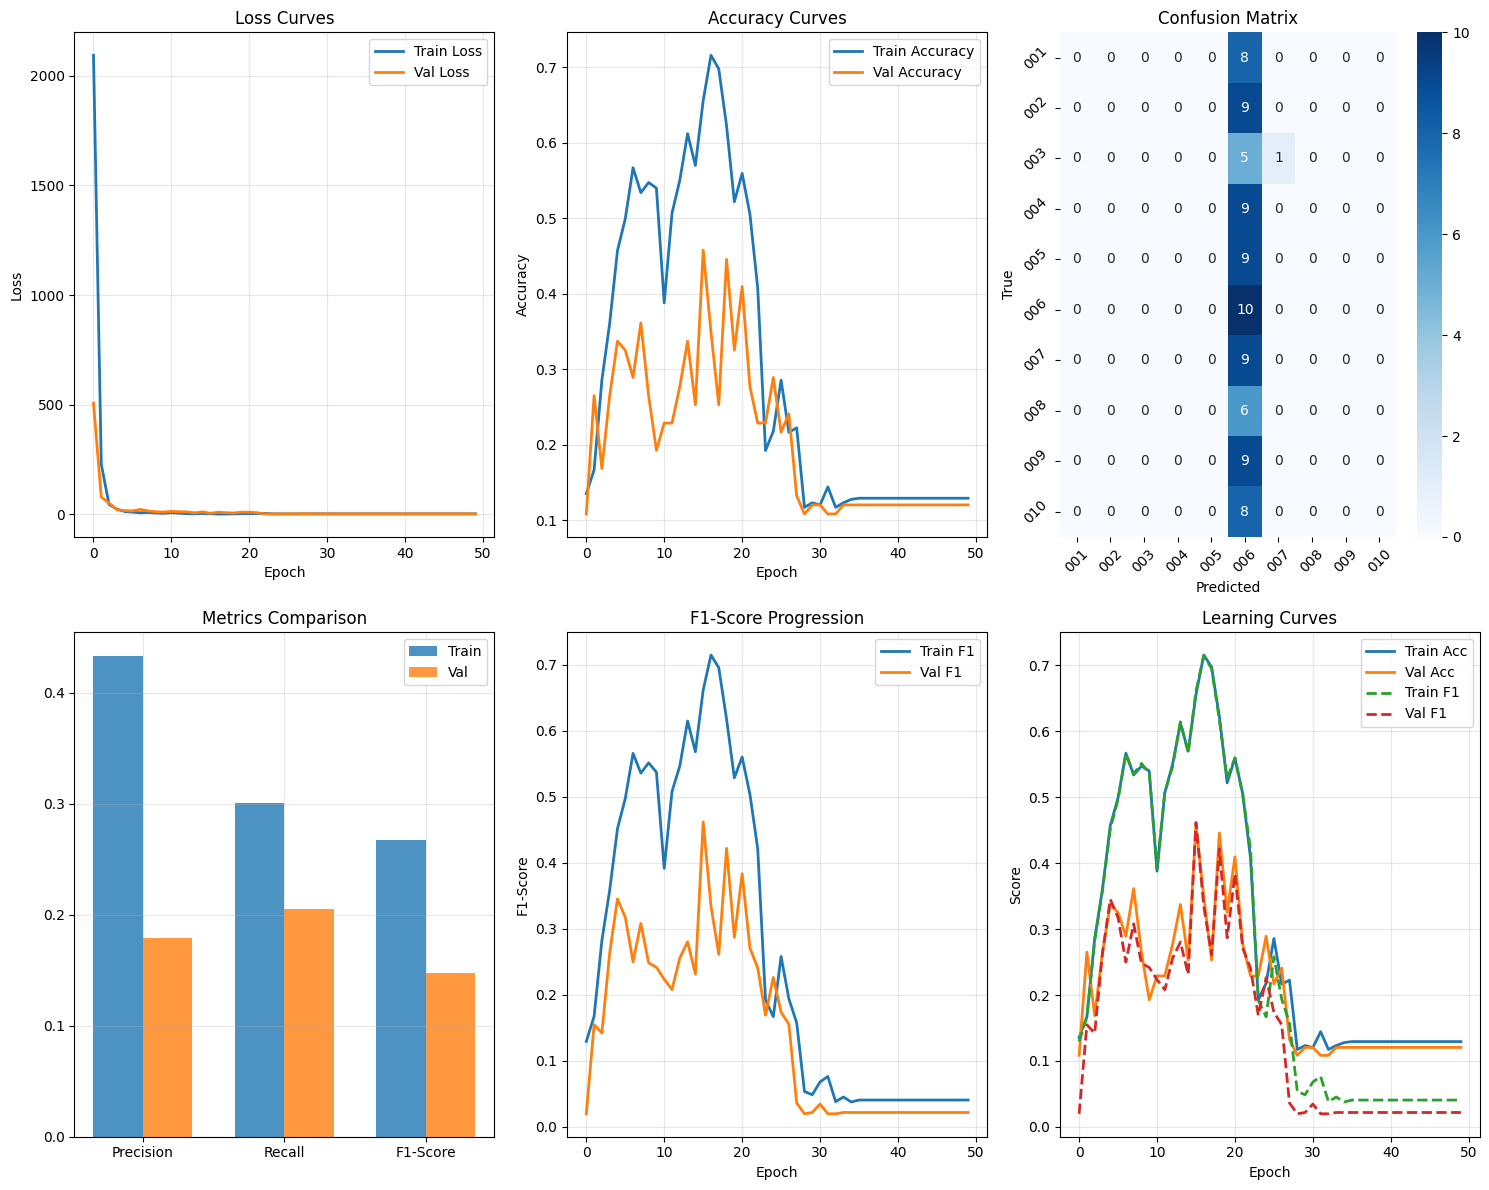

In [ ]:
print("Available configurations:")
for i, (name, config) in enumerate(configs.items()):
    print(f"{i+1}. {name}: {config['layer_configs']}")

# Seleccionar configuración (cambia el índice para probar diferentes configuraciones)
selected_config_name = 'simple_relu_adam'
selected_config = configs[selected_config_name]

print(f"\nTraining with configuration: {selected_config_name}")
print(f"Layers: {selected_config['layer_configs']}")
print(f"Optimizer: {selected_config['optimizer']}")
print(f"Learning rate: {selected_config['lr']}")
print(f"Momentum: {selected_config.get('momentum', 'N/A')}")
print(f"Weight decay: {selected_config.get('weight_decay', 0.0)}")

trained_model, train_metrics, val_metrics = train_model_advanced(selected_config)

In [ ]:
# Evaluar en test
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_accuracy, test_precision, test_recall, test_f1, test_conf_mat = evaluate_model_comprehensive(
    trained_model, test_loader, device
)


COMPREHENSIVE TEST EVALUATION
Average Loss: 2.2866
Accuracy:    0.1071
Precision:   0.0108
Recall:      0.0900
F1-Score:    0.0194

Confusion Matrix:
[[ 0  0  0  0  0  8  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  1  0  9  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]]

Per-class metrics:
  001: Precision=0.000, Recall=0.000, F1=0.000
  002: Precision=0.000, Recall=0.000, F1=0.000
  003: Precision=0.000, Recall=0.000, F1=0.000
  004: Precision=0.000, Recall=0.000, F1=0.000
  005: Precision=0.000, Recall=0.000, F1=0.000
  006: Precision=0.108, Recall=0.900, F1=0.194
  007: Precision=0.000, Recall=0.000, F1=0.000
  008: Precision=0.000, Recall=0.000, F1=0.000
  009: Precision=0.000, Recall=0.000, F1=0.000
  010: Precision=0.000, Recall=0.000, F1=0.000


Available configurations:
1. simple_relu_adam: [(512, 'relu'), (256, 'relu')]
2. sgd_momentum: [(512, 'relu'), (256, 'relu'), (128, 'relu')]
3. rmsprop_momentum: [(1024, 'tanh'), (512, 'tanh')]
4. adamw_config: [(1024, 'leaky_relu'), (512, 'elu'), (256, 'relu')]

Training with configuration: sgd_momentum
Layers: [(512, 'relu'), (256, 'relu'), (128, 'relu')]
Optimizer: sgd
Learning rate: 0.01
Momentum: 0.9
Weight decay: 0.0001
Using device: cpu
Epoch 1/50 | Train Loss: nan | Val Loss: nan | Train Acc: 0.1008 | Val Acc: 0.0964 | LR: 0.010000
Epoch 2/50 | Train Loss: nan | Val Loss: nan | Train Acc: 0.0992 | Val Acc: 0.0964 | LR: 0.010000
Epoch 3/50 | Train Loss: nan | Val Loss: nan | Train Acc: 0.0992 | Val Acc: 0.0964 | LR: 0.010000
Epoch 4/50 | Train Loss: nan | Val Loss: nan | Train Acc: 0.0992 | Val Acc: 0.0964 | LR: 0.010000
Epoch 5/50 | Train Loss: nan | Val Loss: nan | Train Acc: 0.0992 | Val Acc: 0.0964 | LR: 0.010000
Epoch 6/50 | Train Loss: nan | Val Loss: nan | Train Acc: 0.09

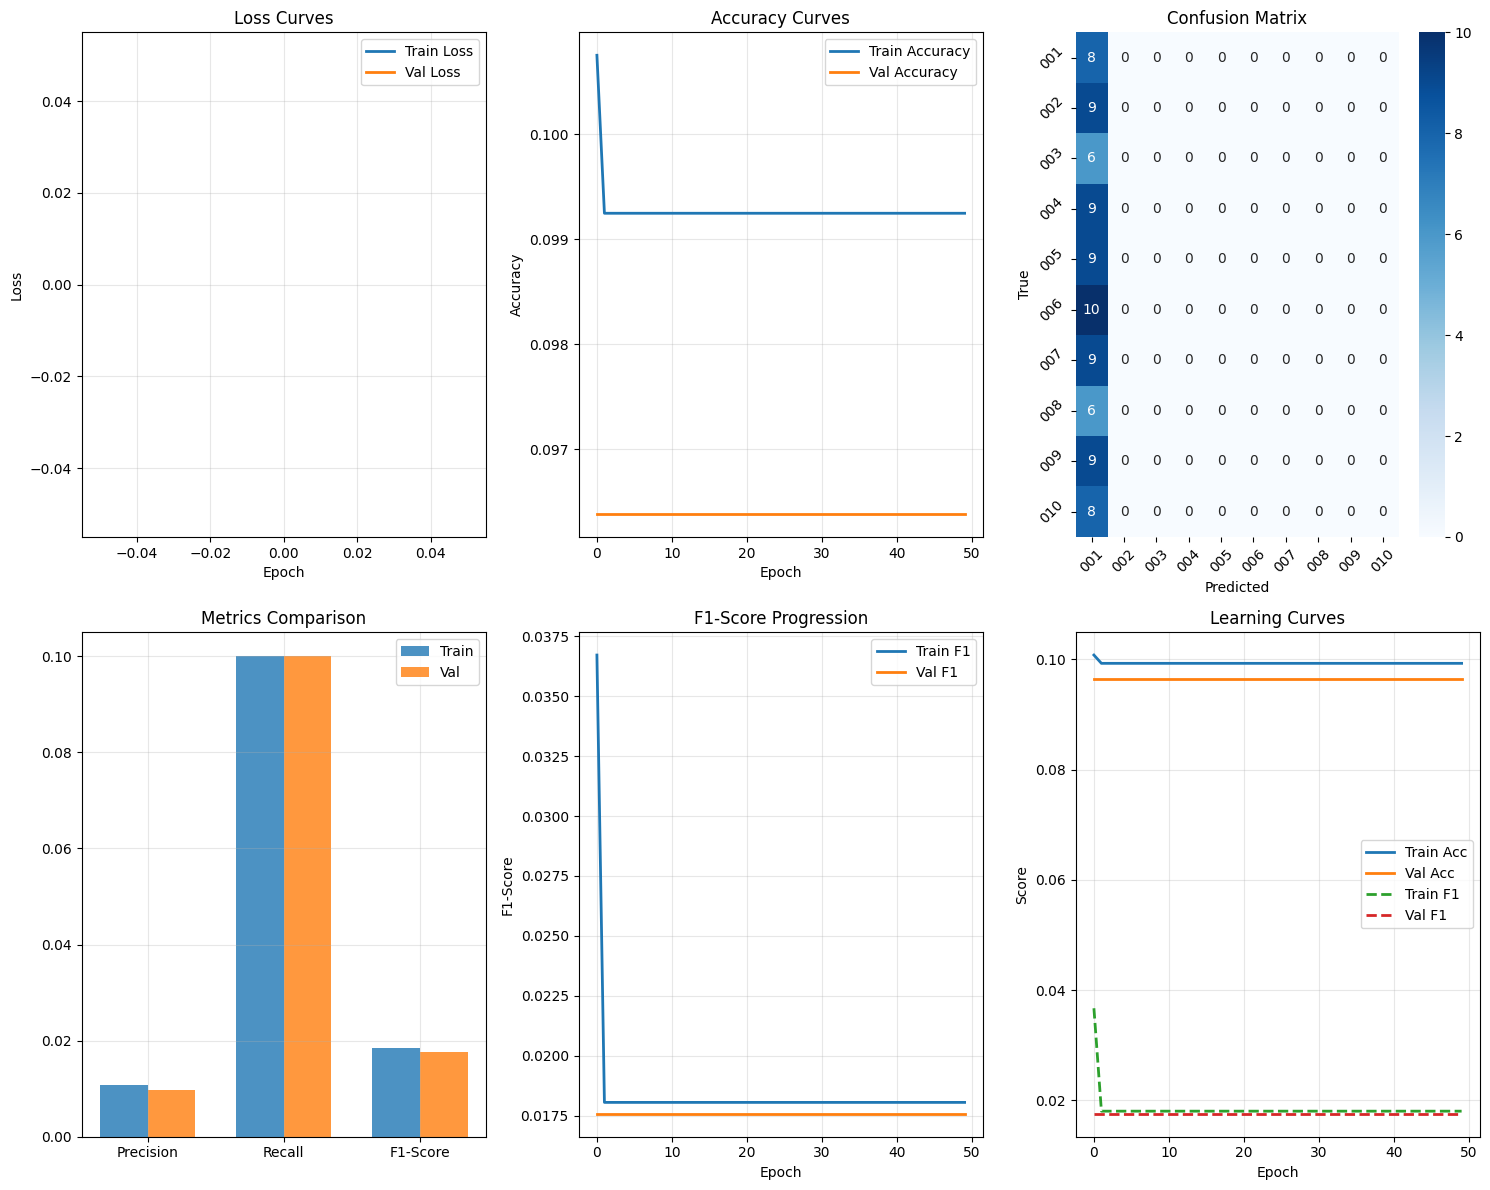

In [ ]:
print("Available configurations:")
for i, (name, config) in enumerate(configs.items()):
    print(f"{i+1}. {name}: {config['layer_configs']}")

# Seleccionar configuración (cambia el índice para probar diferentes configuraciones)
selected_config_name = 'sgd_momentum'
selected_config = configs[selected_config_name]

print(f"\nTraining with configuration: {selected_config_name}")
print(f"Layers: {selected_config['layer_configs']}")
print(f"Optimizer: {selected_config['optimizer']}")
print(f"Learning rate: {selected_config['lr']}")
print(f"Momentum: {selected_config.get('momentum', 'N/A')}")
print(f"Weight decay: {selected_config.get('weight_decay', 0.0)}")

trained_model, train_metrics, val_metrics = train_model_advanced(selected_config)

In [ ]:
# Evaluar en test
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_accuracy, test_precision, test_recall, test_f1, test_conf_mat = evaluate_model_comprehensive(
    trained_model, test_loader, device
)


COMPREHENSIVE TEST EVALUATION
Average Loss: nan
Accuracy:    0.0952
Precision:   0.0095
Recall:      0.1000
F1-Score:    0.0174

Confusion Matrix:
[[ 8  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [ 6  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0  0  0]]

Per-class metrics:
  001: Precision=0.095, Recall=1.000, F1=0.174
  002: Precision=0.000, Recall=0.000, F1=0.000
  003: Precision=0.000, Recall=0.000, F1=0.000
  004: Precision=0.000, Recall=0.000, F1=0.000
  005: Precision=0.000, Recall=0.000, F1=0.000
  006: Precision=0.000, Recall=0.000, F1=0.000
  007: Precision=0.000, Recall=0.000, F1=0.000
  008: Precision=0.000, Recall=0.000, F1=0.000
  009: Precision=0.000, Recall=0.000, F1=0.000
  010: Precision=0.000, Recall=0.000, F1=0.000


Available configurations:
1. simple_relu_adam: [(512, 'relu'), (256, 'relu')]
2. sgd_momentum: [(512, 'relu'), (256, 'relu'), (128, 'relu')]
3. rmsprop_momentum: [(1024, 'tanh'), (512, 'tanh')]
4. adamw_config: [(1024, 'leaky_relu'), (512, 'elu'), (256, 'relu')]

Training with configuration: rmsprop_momentum
Layers: [(1024, 'tanh'), (512, 'tanh')]
Optimizer: rmsprop
Learning rate: 0.0008
Momentum: 0.9
Weight decay: 1e-05
Using device: cpu
Epoch 1/50 | Train Loss: 5.2363 | Val Loss: 4.6620 | Train Acc: 0.0992 | Val Acc: 0.1084 | LR: 0.000800
Epoch 2/50 | Train Loss: 3.2235 | Val Loss: 3.1410 | Train Acc: 0.0932 | Val Acc: 0.0723 | LR: 0.000800
Epoch 3/50 | Train Loss: 2.8993 | Val Loss: 2.8115 | Train Acc: 0.1023 | Val Acc: 0.1205 | LR: 0.000800
Epoch 4/50 | Train Loss: 2.8107 | Val Loss: 2.8673 | Train Acc: 0.0932 | Val Acc: 0.1084 | LR: 0.000800
Epoch 5/50 | Train Loss: 2.9237 | Val Loss: 3.0500 | Train Acc: 0.1233 | Val Acc: 0.1084 | LR: 0.000800
Epoch 6/50 | Train Loss: 2.7246 | Val

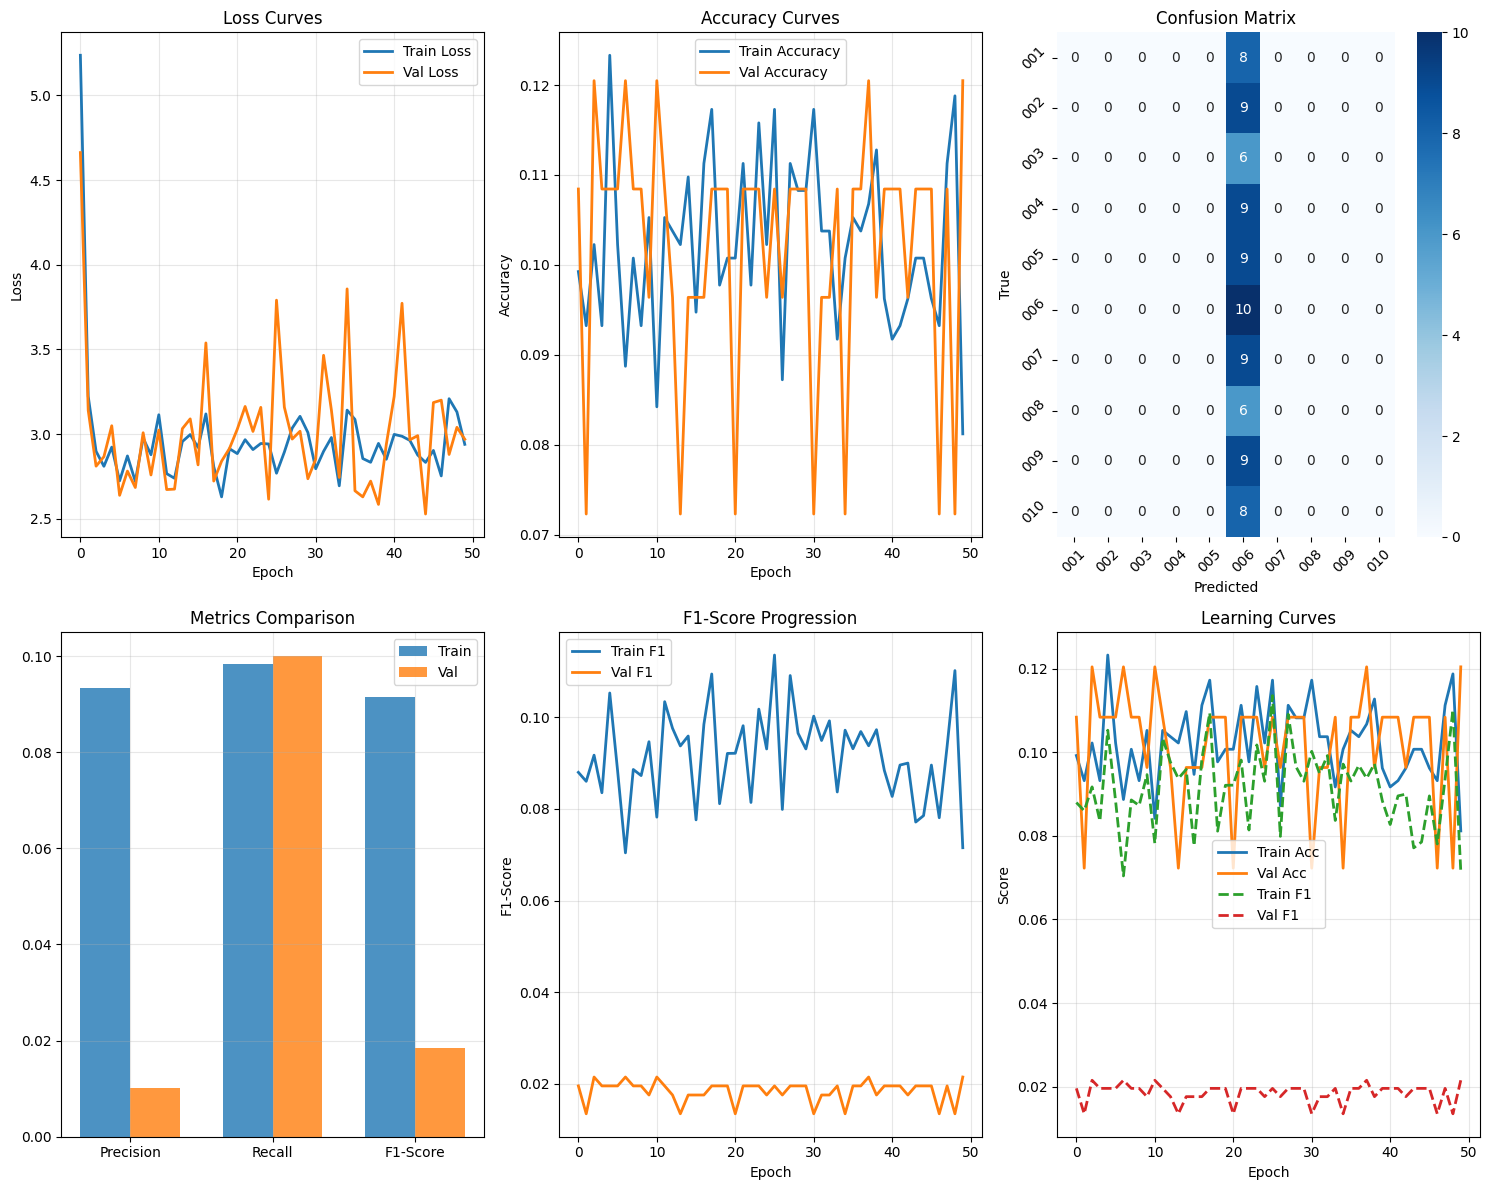

In [ ]:
print("Available configurations:")
for i, (name, config) in enumerate(configs.items()):
    print(f"{i+1}. {name}: {config['layer_configs']}")

# Seleccionar configuración (cambia el índice para probar diferentes configuraciones)
selected_config_name = 'rmsprop_momentum'
selected_config = configs[selected_config_name]

print(f"\nTraining with configuration: {selected_config_name}")
print(f"Layers: {selected_config['layer_configs']}")
print(f"Optimizer: {selected_config['optimizer']}")
print(f"Learning rate: {selected_config['lr']}")
print(f"Momentum: {selected_config.get('momentum', 'N/A')}")
print(f"Weight decay: {selected_config.get('weight_decay', 0.0)}")

trained_model, train_metrics, val_metrics = train_model_advanced(selected_config)

In [ ]:
# Evaluar en test
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_accuracy, test_precision, test_recall, test_f1, test_conf_mat = evaluate_model_comprehensive(
    trained_model, test_loader, device
)


COMPREHENSIVE TEST EVALUATION
Average Loss: 3.0508
Accuracy:    0.1190
Precision:   0.0119
Recall:      0.1000
F1-Score:    0.0213

Confusion Matrix:
[[ 0  0  0  0  0  8  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]]

Per-class metrics:
  001: Precision=0.000, Recall=0.000, F1=0.000
  002: Precision=0.000, Recall=0.000, F1=0.000
  003: Precision=0.000, Recall=0.000, F1=0.000
  004: Precision=0.000, Recall=0.000, F1=0.000
  005: Precision=0.000, Recall=0.000, F1=0.000
  006: Precision=0.119, Recall=1.000, F1=0.213
  007: Precision=0.000, Recall=0.000, F1=0.000
  008: Precision=0.000, Recall=0.000, F1=0.000
  009: Precision=0.000, Recall=0.000, F1=0.000
  010: Precision=0.000, Recall=0.000, F1=0.000


Available configurations:
1. simple_relu_adam: [(512, 'relu'), (256, 'relu')]
2. sgd_momentum: [(512, 'relu'), (256, 'relu'), (128, 'relu')]
3. rmsprop_momentum: [(1024, 'tanh'), (512, 'tanh')]
4. adamw_config: [(1024, 'leaky_relu'), (512, 'elu'), (256, 'relu')]

Training with configuration: adamw_config
Layers: [(1024, 'leaky_relu'), (512, 'elu'), (256, 'relu')]
Optimizer: adamw
Learning rate: 0.0008
Momentum: N/A
Weight decay: 0.0001
Using device: cpu
Epoch 1/50 | Train Loss: 1498.5045 | Val Loss: 626.1739 | Train Acc: 0.1128 | Val Acc: 0.1205 | LR: 0.000800
Epoch 2/50 | Train Loss: 278.7910 | Val Loss: 44.5958 | Train Acc: 0.1684 | Val Acc: 0.1566 | LR: 0.000800
Epoch 3/50 | Train Loss: 58.0738 | Val Loss: 40.8913 | Train Acc: 0.2135 | Val Acc: 0.1807 | LR: 0.000800
Epoch 4/50 | Train Loss: 18.8041 | Val Loss: 14.3588 | Train Acc: 0.2511 | Val Acc: 0.2892 | LR: 0.000800
Epoch 5/50 | Train Loss: 12.5065 | Val Loss: 10.5277 | Train Acc: 0.3293 | Val Acc: 0.3614 | LR: 0.000800
Epoch 6/

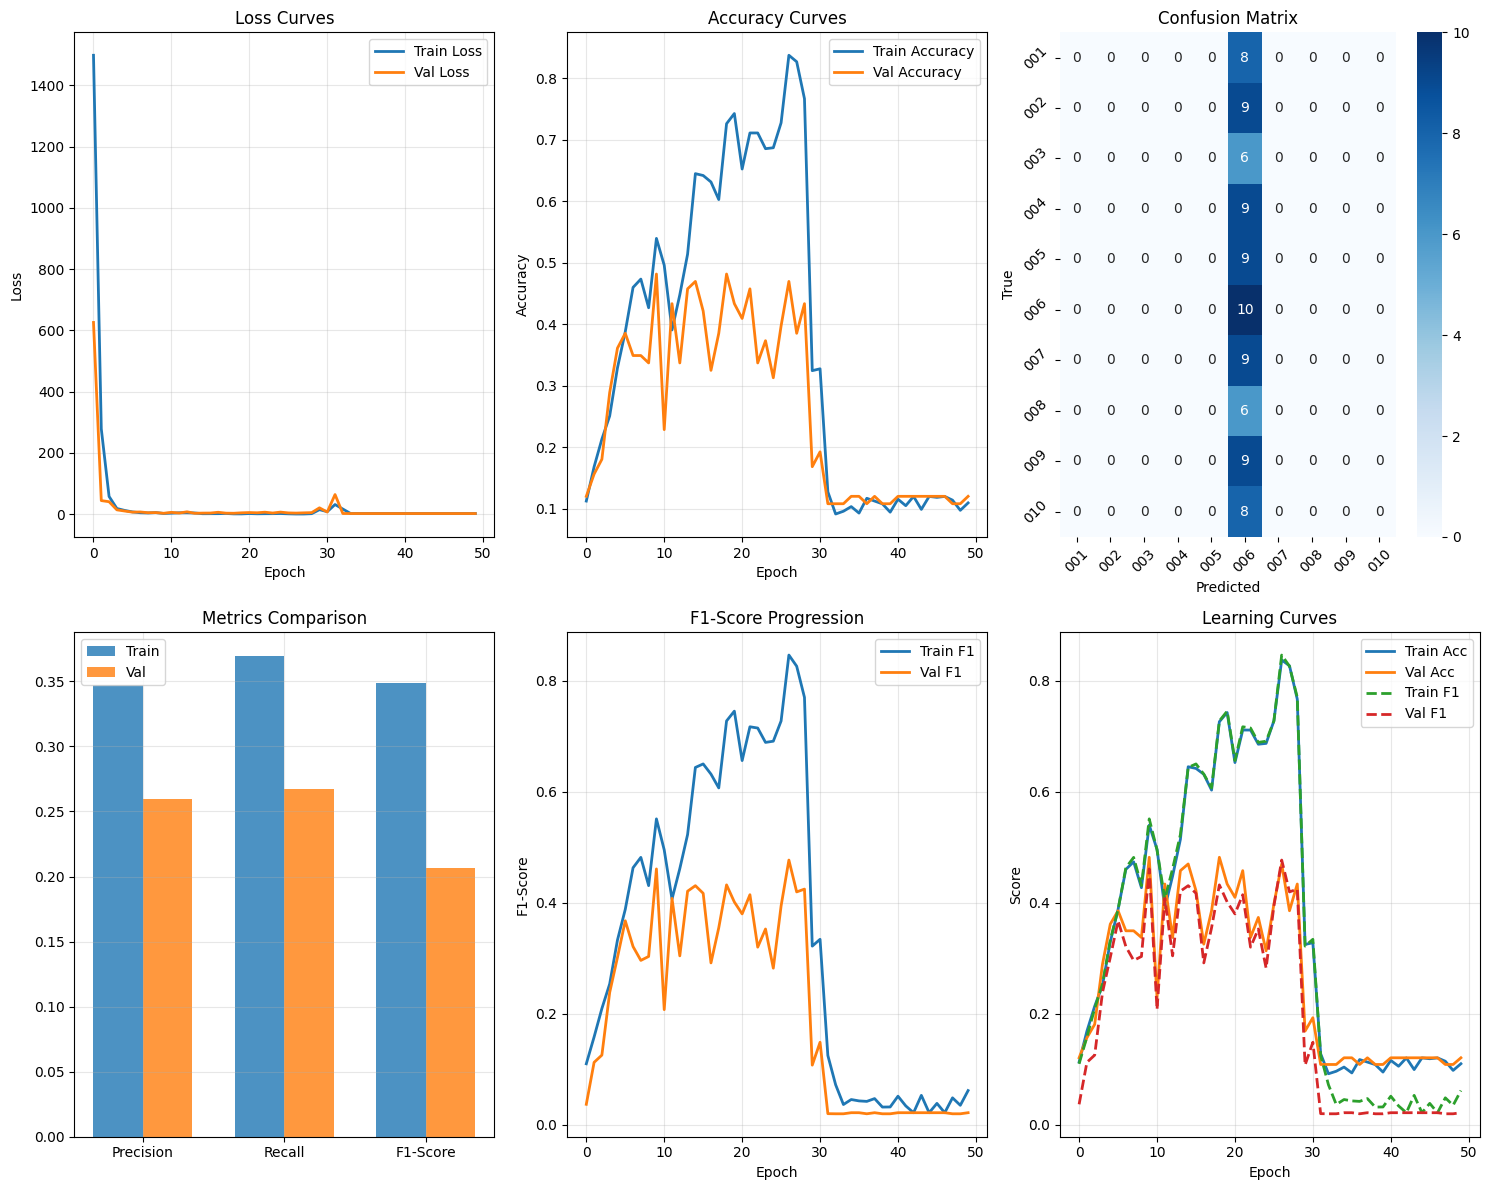

In [ ]:
print("Available configurations:")
for i, (name, config) in enumerate(configs.items()):
    print(f"{i+1}. {name}: {config['layer_configs']}")

# Seleccionar configuración (cambia el índice para probar diferentes configuraciones)
selected_config_name = 'adamw_config'
selected_config = configs[selected_config_name]

print(f"\nTraining with configuration: {selected_config_name}")
print(f"Layers: {selected_config['layer_configs']}")
print(f"Optimizer: {selected_config['optimizer']}")
print(f"Learning rate: {selected_config['lr']}")
print(f"Momentum: {selected_config.get('momentum', 'N/A')}")
print(f"Weight decay: {selected_config.get('weight_decay', 0.0)}")

trained_model, train_metrics, val_metrics = train_model_advanced(selected_config)

In [ ]:
# Evaluar en test
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_accuracy, test_precision, test_recall, test_f1, test_conf_mat = evaluate_model_comprehensive(
    trained_model, test_loader, device
)


COMPREHENSIVE TEST EVALUATION
Average Loss: 2.2754
Accuracy:    0.1190
Precision:   0.0119
Recall:      0.1000
F1-Score:    0.0213

Confusion Matrix:
[[ 0  0  0  0  0  8  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]]

Per-class metrics:
  001: Precision=0.000, Recall=0.000, F1=0.000
  002: Precision=0.000, Recall=0.000, F1=0.000
  003: Precision=0.000, Recall=0.000, F1=0.000
  004: Precision=0.000, Recall=0.000, F1=0.000
  005: Precision=0.000, Recall=0.000, F1=0.000
  006: Precision=0.119, Recall=1.000, F1=0.213
  007: Precision=0.000, Recall=0.000, F1=0.000
  008: Precision=0.000, Recall=0.000, F1=0.000
  009: Precision=0.000, Recall=0.000, F1=0.000
  010: Precision=0.000, Recall=0.000, F1=0.000


**Evaluación en Test**

# **CNN**

**Parámetros del Modelo**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class ConfigurableCNN(nn.Module):
    def __init__(self, input_channels, conv_configs, fc_configs, num_classes, dropout_rate=0.5):

        super(ConfigurableCNN, self).__init__()

        # Capas convolucionales
        self.conv_layers = nn.ModuleList()
        in_channels = input_channels

        for out_channels, kernel_size, stride, padding in conv_configs:
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                    nn.MaxPool2d(2, 2)  # Pooling después de cada conv
                )
            )
            in_channels = out_channels

        # Calcular tamaño de feature maps después de las convoluciones
        self._calculate_fc_input_size(m, n, conv_configs)

        # Capas fully connected
        self.fc_layers = nn.ModuleList()
        prev_size = self.fc_input_size

        for fc_size in fc_configs:
            self.fc_layers.append(
                nn.Sequential(
                    nn.Linear(prev_size, fc_size),
                    nn.BatchNorm1d(fc_size),
                    nn.ReLU(),
                    nn.Dropout(dropout_rate)
                )
            )
            prev_size = fc_size

        # Capa de salida
        self.output_layer = nn.Linear(prev_size, num_classes)

        # Inicialización de pesos
        self._initialize_weights()

    def _calculate_fc_input_size(self, height, width, conv_configs):
        """Calcular automáticamente el tamaño de entrada para las capas FC"""
        # Simular el forward para calcular dimensiones
        x = torch.randn(1, 3, height, width)

        for conv_layer in self.conv_layers:
            x = conv_layer(x)

        self.fc_input_size = x.view(1, -1).size(1)
        print(f"Feature map size after convolutions: {x.size()}")
        print(f"FC input size: {self.fc_input_size}")

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        # Capas convolucionales
        for conv_layer in self.conv_layers:
            x = conv_layer(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Capas fully connected
        for fc_layer in self.fc_layers:
            x = fc_layer(x)

        # Salida
        return self.output_layer(x)

In [ ]:
def prepare_cnn_data(X_train, X_val, X_test, y_train, y_val, y_test, m, n):

    print("=== PREPARING DATA FOR CNN ===")

    # Convertir a tensores
    X_train_t = torch.FloatTensor(X_train).reshape(-1, 3, m, n)
    X_val_t = torch.FloatTensor(X_val).reshape(-1, 3, m, n)
    X_test_t = torch.FloatTensor(X_test).reshape(-1, 3, m, n)

    # Normalización (muy importante para CNN)
    mean = X_train_t.mean(dim=[0, 2, 3], keepdim=True)
    std = X_train_t.std(dim=[0, 2, 3], keepdim=True)

    X_train_t = (X_train_t - mean) / (std + 1e-8)
    X_val_t = (X_val_t - mean) / (std + 1e-8)
    X_test_t = (X_test_t - mean) / (std + 1e-8)

    print(f"Normalized - Mean: {mean.squeeze()}, Std: {std.squeeze()}")
    print(f"Data range: [{X_train_t.min():.3f}, {X_train_t.max():.3f}]")

    # Codificar labels
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)

    y_train_t = torch.LongTensor(y_train_encoded)
    y_val_t = torch.LongTensor(y_val_encoded)
    y_test_t = torch.LongTensor(y_test_encoded)

    print(f"Classes: {label_encoder.classes_}")
    print(f"Class distribution: {np.bincount(y_train_encoded)}")

    return X_train_t, X_val_t, X_test_t, y_train_t, y_val_t, y_test_t, label_encoder

# Preparar datos
X_train_cnn, X_val_cnn, X_test_cnn, y_train_cnn, y_val_cnn, y_test_cnn, label_encoder = prepare_cnn_data(
    X_train, X_val, X_test, y_train, y_val, y_test, m, n
)

=== PREPARING DATA FOR CNN ===
Normalized - Mean: tensor([108.8369,  97.7459, 106.0820]), Std: tensor([70.6967, 71.2716, 71.7763])
Data range: [-1.539, 2.206]
Classes: ['001' '002' '003' '004' '005' '006' '007' '008' '009' '010']
Class distribution: [66 74 49 72 70 80 71 44 72 67]


In [ ]:
def train_cnn(model_config, train_config):
    """
    Entrenar CNN con configuración flexible
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Crear modelo CNN
    model = ConfigurableCNN(
        input_channels=3,
        conv_configs=model_config['conv_layers'],
        fc_configs=model_config['fc_layers'],
        num_classes=len(label_encoder.classes_),
        dropout_rate=model_config.get('dropout', 0.5)
    ).to(device)

    print(f"Model architecture:")
    print(model)
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss function y optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=train_config['lr'],
        weight_decay=train_config.get('weight_decay', 1e-4)
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    # DataLoaders
    train_dataset = TensorDataset(X_train_cnn, y_train_cnn)
    val_dataset = TensorDataset(X_val_cnn, y_val_cnn)
    test_dataset = TensorDataset(X_test_cnn, y_test_cnn)

    train_loader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=train_config['batch_size'])
    test_loader = DataLoader(test_dataset, batch_size=train_config['batch_size'])

    # Entrenamiento
    best_val_acc = 0
    patience_counter = 0
    patience = 15

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'learning_rates': []
    }

    for epoch in range(train_config['epochs']):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # Calcular métricas
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total

        # Actualizar historia
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch+1:3d}/{train_config["epochs"]} | '
              f'Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | '
              f'Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | '
              f'LR: {optimizer.param_groups[0]["lr"]:.2e}')

        # Early stopping y guardar mejor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, 'best_cnn_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Cargar mejor modelo
    model.load_state_dict(best_model_state)

    return model, history

# 4. Evaluación completa
def evaluate_cnn_model(model, test_loader, label_encoder, device='cpu'):
    """Evaluación exhaustiva del modelo CNN"""
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Métricas
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds,
                                  target_names=label_encoder.classes_)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"\n{'='*60}")
    print(f"CNN MODEL EVALUATION")
    print(f"{'='*60}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:")
    print(report)

    # Matriz de confusión visual
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix - CNN Model')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return accuracy, report, conf_matrix

In [ ]:
# Configuraciones de modelo predefinidas
cnn_configs = {
    'simple_cnn': {
        'conv_layers': [
            (32, 3, 1, 1),
            (64, 3, 1, 1),
            (128, 3, 1, 1)
        ],
        'fc_layers': [512, 256],
        'dropout': 0.5
    },

    'deep_cnn': {
        'conv_layers': [
            (64, 3, 1, 1),
            (128, 3, 1, 1),
            (256, 3, 1, 1),
            (512, 3, 1, 1)
        ],
        'fc_layers': [1024, 512, 256],
        'dropout': 0.6
    },

    'wide_cnn': {
        'conv_layers': [
            (128, 5, 1, 2),
            (256, 5, 1, 2),
            (512, 3, 1, 1)
        ],
        'fc_layers': [1024, 512],
        'dropout': 0.4
    }
}

# Configuración de entrenamiento
train_config = {
    'batch_size': 32,
    'lr': 0.001,
    'weight_decay': 1e-4,
    'epochs': 50
}


Available CNN architectures:
1. simple_cnn: [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]
2. deep_cnn: [(64, 3, 1, 1), (128, 3, 1, 1), (256, 3, 1, 1), (512, 3, 1, 1)]
3. wide_cnn: [(128, 5, 1, 2), (256, 5, 1, 2), (512, 3, 1, 1)]

Training simple_cnn architecture...
Using device: cpu
Feature map size after convolutions: torch.Size([1, 128, 22, 22])
FC input size: 61952
Model architecture:
ConfigurableCNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, 

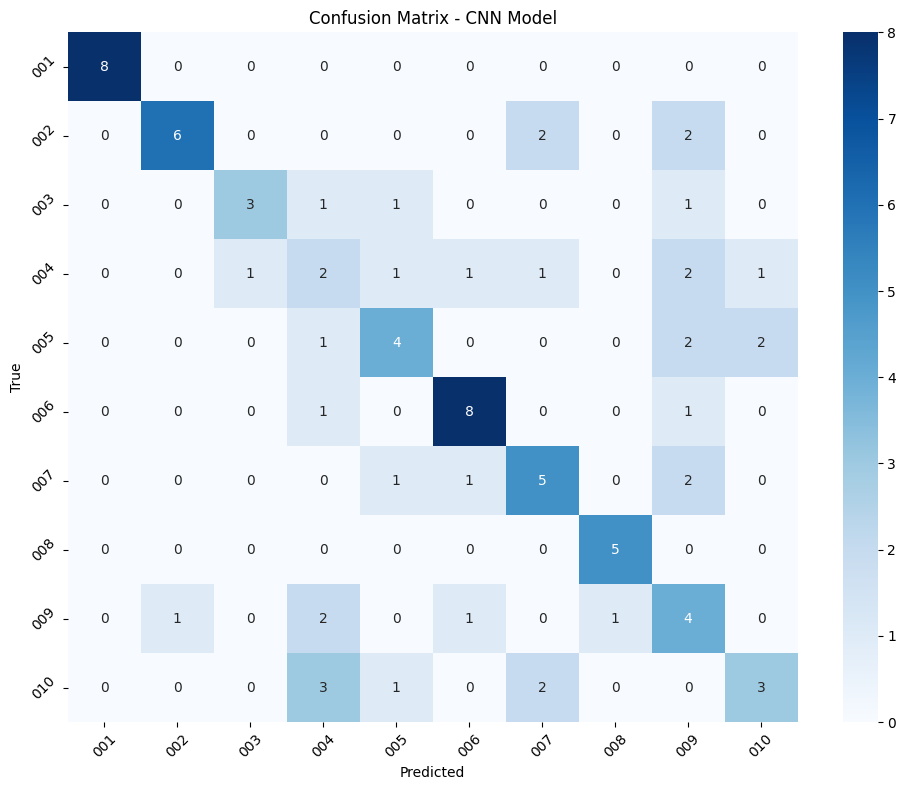

In [ ]:
# 5. Entrenar y evaluar
print("Available CNN architectures:")
for i, (name, config) in enumerate(cnn_configs.items()):
    print(f"{i+1}. {name}: {config['conv_layers']}")

# Seleccionar arquitectura
selected_arch = 'simple_cnn'
print(f"\nTraining {selected_arch} architecture...")

# Entrenar CNN
trained_cnn, history = train_cnn(cnn_configs[selected_arch], train_config)

# Evaluar en test
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loader = DataLoader(TensorDataset(X_test_cnn, y_test_cnn), batch_size=32)

test_accuracy, report, conf_matrix = evaluate_cnn_model(
    trained_cnn, test_loader, label_encoder, device
)

In [ ]:
# 5. Entrenar y evaluar
print("Available CNN architectures:")
for i, (name, config) in enumerate(cnn_configs.items()):
    print(f"{i+1}. {name}: {config['conv_layers']}")

# Seleccionar arquitectura
selected_arch = 'deep_cnn'
print(f"\nTraining {selected_arch} architecture...")

# Entrenar CNN
trained_cnn, history = train_cnn(cnn_configs[selected_arch], train_config)

# Evaluar en test
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loader = DataLoader(TensorDataset(X_test_cnn, y_test_cnn), batch_size=32)

test_accuracy, report, conf_matrix = evaluate_cnn_model(
    trained_cnn, test_loader, label_encoder, device
)

Available CNN architectures:
1. simple_cnn: [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 1, 1)]
2. deep_cnn: [(64, 3, 1, 1), (128, 3, 1, 1), (256, 3, 1, 1), (512, 3, 1, 1)]
3. wide_cnn: [(128, 5, 1, 2), (256, 5, 1, 2), (512, 3, 1, 1)]

Training deep_cnn architecture...
Using device: cpu
Feature map size after convolutions: torch.Size([1, 512, 11, 11])
FC input size: 61952
Model architecture:
ConfigurableCNN(
  (conv_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [ ]:
# 5. Entrenar y evaluar
print("Available CNN architectures:")
for i, (name, config) in enumerate(cnn_configs.items()):
    print(f"{i+1}. {name}: {config['conv_layers']}")

# Seleccionar arquitectura
selected_arch = 'wide_cnn'
print(f"\nTraining {selected_arch} architecture...")

# Entrenar CNN
trained_cnn, history = train_cnn(cnn_configs[selected_arch], train_config)

# Evaluar en test
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loader = DataLoader(TensorDataset(X_test_cnn, y_test_cnn), batch_size=32)

test_accuracy, report, conf_matrix = evaluate_cnn_model(
    trained_cnn, test_loader, label_encoder, device
)

In [ ]:
def visualize_feature_maps(model, sample_image, layer_names=None):
    """Visualizar feature maps de las capas convolucionales"""
    model.eval()

    # Determine the device of the model
    device = next(model.parameters()).device
    print(f"Model is on device: {device}")

    # Move the sample image to the same device as the model
    sample_image = sample_image.to(device)
    print(f"Sample image moved to device: {sample_image.device}")


    # Hook para capturar feature maps
    feature_maps = {}

    def get_feature_map(name):
        def hook(model, input, output):
            feature_maps[name] = output.detach()
        return hook

    # Registrar hooks
    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(get_feature_map(name)))

    # Forward pass
    with torch.no_grad():
        model(sample_image.unsqueeze(0))

    # Remover hooks
    for hook in hooks:
        hook.remove()

    # Visualizar feature maps
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    # Filter out layers if specific names are provided
    if layer_names:
        filtered_feature_maps = {name: features for name, features in feature_maps.items() if name in layer_names}
    else:
        filtered_feature_maps = feature_maps


    for i, (name, features) in enumerate(filtered_feature_maps.items()):
        if i >= len(axes): # Ensure we don't exceed the number of subplots
            break

        # Take the first feature map of the first channel
        # Detach and move to CPU for plotting
        feature_map = features[0, 0].detach().cpu().numpy()
        axes[i].imshow(feature_map, cmap='viridis')
        axes[i].set_title(f'Layer: {name}\nShape: {features.shape[2:]}')
        axes[i].axis('off')

    # Hide unused subplots if there are fewer feature maps than subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])


    plt.tight_layout()
    plt.show()

# Visualizar feature maps de una imagen de ejemplo
sample_idx = 0
sample_image = X_test_cnn[sample_idx]
visualize_feature_maps(trained_cnn, sample_image)